# Simulation of User Preferences

In [1]:
import os
import pandas as pd
import numpy as np
from vigor import generate_graphs, nobre_predicates, predicates, compute_metrics, Predicate, VIGOR, label_graphs, learn_predicates

## Generate graphs

1. Generate graphs using the fast_gnp_random_graph function from networkx
2. Calculate statistics for each graph

In [2]:
file_path = '../data/generated_graphs_example'

if not os.path.exists(f'{file_path}.csv'):
    print('Generating graph data')
    graphs = generate_graphs(100, 2, 200)
    graphs.to_csv(f'{file_path}.csv', index=False)
else:
    print('Loading graph data')
    graphs = pd.read_csv(f'{file_path}.csv')

Loading graph data


In [3]:
graphs.head()

,graph_type,is_directed_int,has_spatial_attributes,has_temporal_attributes,is_bipartite,n_components,avg_betweenness_centrality,avg_closeness_centrality,avg_eigenvector_centrality,avg_degree,...,eccentricity_avg,n_nodes,node_types,node_attributes,number_of_isolates,density,edge_types,edge_attributes,n_parallel_edges,n_self_loops
0,4,1,0,1,0,2,0.006843,0.504436,0.080592,17.356164,...,3.000000,146,3,6,0,0.119698,5,2,2,5
1,4,0,0,0,0,7,0.011514,0.554609,0.114805,15.666667,...,2.736111,72,1,2,0,0.220657,4,12,0,4
2,4,1,0,1,0,9,0.034914,0.568343,0.198937,6.916667,...,2.666667,24,4,7,0,0.300725,5,15,3,1
3,4,0,0,0,1,1,0.007891,0.561783,0.097868,22.376238,...,2.356436,101,1,4,0,0.223762,4,1,0,0
4,4,0,1,1,1,5,0.004791,0.659691,0.094859,52.600000,...,2.000000,110,1,0,0,0.482569,3,0,0,4


## Sample designers

We evaluate the ability of VIGOR to recover the rules that were used to represent simulated users. We design 3 versions of this simulated user: bob_informed, who follows the rules 100\% of the time; bob_semi_informed, who follows the rules 75\% of the time and chooses other visualizations randomly the other 25\% of the time; and bob_uninformed who follows the rules 50\% of the time and chooses other visualizations randomly the other 50\% of the time.

In [5]:
informed = label_graphs(graphs, predicates, conformance=1)
semi_informed = label_graphs(graphs, predicates, conformance=0.75)
uninformed = label_graphs(graphs, predicates, conformance=0.5)

In [6]:
informed

0       MATRIX
1      PAOHVIS
2     NODETRIX
3       MATRIX
4      PAOHVIS
        ...   
94      MATRIX
95    NODELINK
96      MATRIX
97     PAOHVIS
98      MATRIX
Length: 99, dtype: object

### Learning predicates from labeled data

In [7]:
graphs['graph_type'].value_counts()

graph_type
4    84
3    15
Name: count, dtype: int64

In [8]:
graph_types = graphs['graph_type'].unique()
graphs['graph_type_' + pd.Series(graph_types).astype(str)] = (graphs['graph_type'].values[None] == graph_types[:,None]).astype(int).T
graphs = graphs.drop('graph_type', axis=1)

In [9]:
learned_predicates_informed = learn_predicates(graphs, informed, 1000)
learned_predicates_semi_informed = learn_predicates(graphs, semi_informed, 1000)
learned_predicates_uninformed = learn_predicates(graphs, uninformed, 1000)

Learning predicates for MATRIX
[   0] loss 6.713448524475098
[ 100] loss 6.141830921173096
[ 200] loss 5.602607727050781
[ 300] loss 5.072093486785889
[ 400] loss 4.536035060882568
[ 500] loss 3.9803128242492676
[ 600] loss 3.411426067352295
[ 700] loss 2.816307306289673
[ 800] loss 2.1140213012695312
[ 900] loss 1.2985459566116333
[   0] loss 14.926185607910156
[ 100] loss 13.7543306350708
[ 200] loss 12.594588279724121
[ 300] loss 11.424334526062012
[ 400] loss 10.180281639099121
[ 500] loss 8.728325843811035
[ 600] loss 7.28141975402832
[ 700] loss 6.017764091491699
[ 800] loss 4.679215908050537
[ 900] loss 3.09749174118042
Learning predicates for PAOHVIS
[   0] loss 6.90689754486084
[ 100] loss 6.323080062866211
[ 200] loss 5.765058994293213
[ 300] loss 5.230952739715576
[ 400] loss 4.7114949226379395
[ 500] loss 4.186191558837891
[ 600] loss 3.6438863277435303
[ 700] loss 3.0657873153686523
[ 800] loss 2.4013445377349854
[ 900] loss 1.6201856136322021
[   0] loss 14.8517427444458


### Comparing learned predicates to initial predicates

#### Informed User

In [10]:
evaluation_informed = compute_metrics(predicates, learned_predicates_informed)
print(evaluation_informed)

{'MATRIX': {'modularity': {'iou': 0.0, 'deviation': 0.5000941662324991, 'inclusion': 0}}, 'PAOHVIS': {}, 'NODETRIX': {'avg_degree': {'iou': 0.0, 'deviation': 6.511415523195167, 'inclusion': 0}, 'modularity': {'iou': 0.0, 'deviation': 0.5500941662324992, 'inclusion': 0}, 'communities': {'iou': 0.0, 'deviation': 5.0, 'inclusion': 0}}, 'NODELINK': {'avg_degree': {'iou': 0.0, 'deviation': 14.511415523195167, 'inclusion': 0}}}


#### Semi-Informed User

In [11]:
evaluation_semi_informed = compute_metrics(predicates, learned_predicates_semi_informed)
print(evaluation_semi_informed)

{np.str_('PAOHVIS'): {}, np.str_('NODETRIX'): {'avg_degree': {'iou': 0.0, 'deviation': 6.511415523195167, 'inclusion': 0}, 'modularity': {'iou': 0.0, 'deviation': 0.5500941662324992, 'inclusion': 0}, 'communities': {'iou': 0.0, 'deviation': 5.0, 'inclusion': 0}}, 'MATRIX': {'modularity': {'iou': 0.0, 'deviation': 0.5000941662324991, 'inclusion': 0}}, 'NODELINK': {'avg_degree': {'iou': 0.0, 'deviation': 14.511415523195167, 'inclusion': 0}}, np.str_('CHORD_DIAGRAM'): {'avg_degree': {'iou': 0.0, 'deviation': 13.511415523195167, 'inclusion': 0}}, np.str_('TREEMAP'): {'modularity': {'iou': 0.0, 'deviation': 0.7500941662324991, 'inclusion': 0}}, np.str_('NODELINK_MAP'): {'avg_degree': {'iou': 0.0, 'deviation': 13.511415523195167, 'inclusion': 0}}}


#### Unformed User

In [12]:
evaluation_uninformed = compute_metrics(predicates, learned_predicates_uninformed)
print(evaluation_uninformed)

{np.str_('NODETRIX'): {'avg_degree': {'iou': 0.0, 'deviation': 6.511415523195167, 'inclusion': 0}, 'modularity': {'iou': 0.0, 'deviation': 0.5500941662324992, 'inclusion': 0}, 'communities': {'iou': 0.0, 'deviation': 5.0, 'inclusion': 0}}, np.str_('NODELINK'): {'avg_degree': {'iou': 0.0, 'deviation': 14.511415523195167, 'inclusion': 0}}, 'MATRIX': {'avg_degree': {'iou': 0.04223744291692322, 'deviation': 19.155251141661537, 'inclusion': 1}, 'modularity': {'iou': 0.0, 'deviation': 0.5000941662324991, 'inclusion': 0}}, np.str_('NODELINK_MAP'): {'avg_degree': {'iou': 0.0, 'deviation': 13.511415523195167, 'inclusion': 0}}, np.str_('PAOHVIS'): {'avg_degree': {'iou': 0.0, 'deviation': 9.011415523195167, 'inclusion': 0}}, np.str_('CHORD_DIAGRAM'): {'avg_degree': {'iou': 0.0, 'deviation': 13.511415523195167, 'inclusion': 0}}, np.str_('TREEMAP'): {'modularity': {'iou': 0.0, 'deviation': 0.7500941662324991, 'inclusion': 0}}}


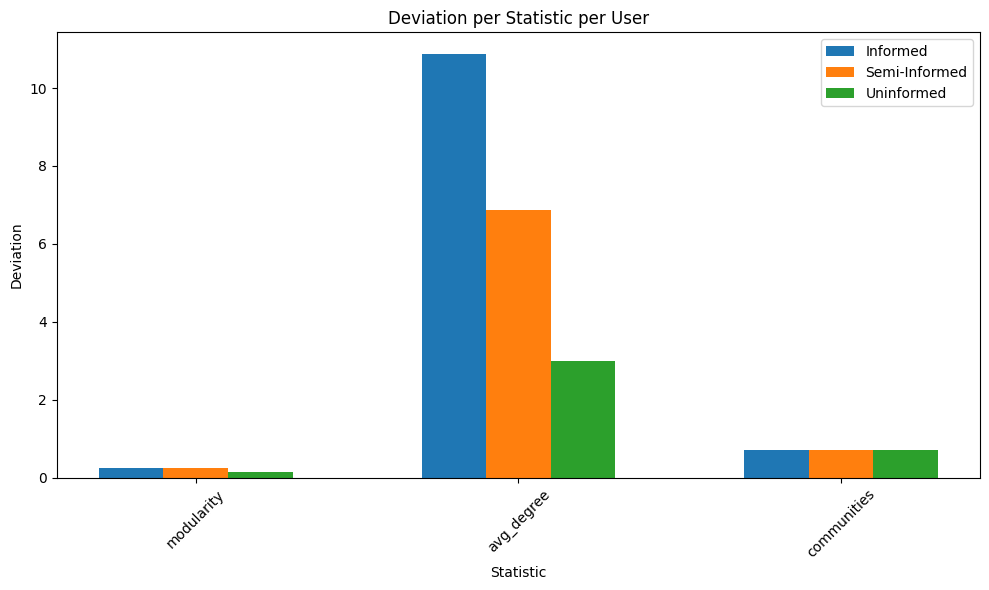

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict

results = [evaluation_informed, evaluation_semi_informed, evaluation_uninformed]

# Flatten the data for plotting
def extract_deviations(results):
    deviations = defaultdict(lambda: defaultdict(list))
    for user, user_data in enumerate(results):
        for vis_type, vis_data in user_data.items():
            for stat, stat_data in vis_data.items():
                if 'deviation' in stat_data:
                    deviations[stat][vis_type].append(stat_data['deviation'])
    return deviations

deviations = extract_deviations(results)

stat_names = list(deviations.keys())
visualization_types = list(set(v for vis_dict in deviations.values() for v in vis_dict.keys()))  # All unique visualization types

# Use these custom labels instead of "User 1", "User 2", "User 3"
user_labels = ['Informed', 'Semi-Informed', 'Uninformed']

bar_width = 0.2
index = np.arange(len(stat_names))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each "user" (informed, semi-informed, uninformed)
for i, user in enumerate(user_labels):
    deviation_values = []
    for stat in stat_names:
        user_devs = []
        for vis_type in visualization_types:
            if len(deviations[stat][vis_type]) > i:
                user_devs.append(deviations[stat][vis_type][i])
            else:
                user_devs.append(0)  # Fill with 0 if the user does not have this visualization type
        deviation_values.append(np.mean(user_devs))  # Average deviation for each statistic

    ax.bar(index + i * bar_width, deviation_values, bar_width, label=user)

# Labeling the axes and the chart
ax.set_xlabel('Statistic')
ax.set_ylabel('Deviation')
ax.set_title('Deviation per Statistic per User')
ax.set_xticks(index + bar_width * (len(user_labels) - 1) / 2)
ax.set_xticklabels(stat_names, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()